In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import constants

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

<h4>X, A準位の振動回転エネルギー (cm^-1) (NIST Chemistry Webbook)</h4>

In [2]:
def BH_ene_X(v, N):
    # 分子定数 (NIST Chemistry webbook)
    # Molecular constants (NIST Chemistry webbook)
    T_e = 0
    omega_e = 2366.9
    omega_e_x_e = 49.39
    omega_e_y_e = 0.364
    B_e = 12.021
    alpha_e = 0.412
    D_e = 0.001242
    beta_e = -0.000026
    
    B_v = B_e - alpha_e*(v + 1/2)
    D_v = D_e - beta_e*(v + 1/2)
    
    G = omega_e*(v + 1/2) - omega_e_x_e*(v + 1/2)**2 + omega_e_y_e*(v + 1/2)**3
    F = B_v*N*(N + 1) - D_v*N**2*(N + 1)**2
    
    return T_e + G + F   

In [3]:
def BH_ene_A(v, N):
    # 分子定数 (NIST Chemistry webbook)
    # Molecular constants (NIST Chemistry webbook)
    # https://webbook.nist.gov/chemistry/
    T_e = 23135.8
    omega_e = 2250.9
    omega_e_x_e = 56.66
    omega_e_y_e = -15.83
    B_e = 12.295
    alpha_e = 0.8346
    D_e = 0.001451
    beta_e = 0
    
    B_v = B_e - alpha_e*(v + 1/2)
    D_v = D_e - beta_e*(v + 1/2)
    
    G = omega_e*(v + 1/2) - omega_e_x_e*(v + 1/2)**2 + omega_e_y_e*(v + 1/2)**3
    F = B_v*N*(N + 1) - D_v*N**2*(N + 1)**2
        
    return T_e + G + F   

<h4>空気の屈折率, wl (nm) (理科年表)</h4>

In [4]:
def n_air(wl):
    wl *= 1e3 # (um)
    tmp = 6432.8 + 2949810/(146 - 1/wl**2) + 25540/(41 - 1/wl**2)
    
    return tmp*1e-8 + 1

<h4>A係数 (Luh, JMS (1983), Tab.XII)</h4>

In [5]:
def A(v, N2, N1):
    
    # 振動まで分けたA係数 (s^-1) 
    A_vib = 7.2356e-6*np.array([0.16135e13, 0.13678e13, 0.10345e13])    
    
    # ヘンル=ロンドン因子
    if N2 - N1 == -1: # P枝
        HLF = N2/2
    elif N2 - N1 == 0: # Q枝
        HLF = (2*N2 + 1)/2
    elif N2 - N1 == 1: # R枝
        HLF = (N2 + 1)/2
    
    return A_vib[v]*HLF/(2*N2 + 1)

<h4>輝線形状</h4>

In [6]:
def line_prof(x, wl, w_inst, T):

    # ドップラー幅
    K2eV = 8.617e-5
    M_BH = 11.81
    w_D = 7.72e-5*wl*np.sqrt(T*K2eV/M_BH)

    # 線幅
    w = np.sqrt(w_D**2 + w_inst**2)
    
    # 標準偏差
    sigma = w/(2*np.sqrt(2*np.log(2)))
    
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - wl)**2/(2*sigma**2))

<h4>A-X帯スペクトル計算</h4>

In [7]:
def BH_spec(x, C, T_rot, w_inst, T_tra, branch):
    # 振動回転準位の範囲
    v_min = 0
    v_max = 2
    N2_min = 1
    N2_max = 22
        
    # 変換係数
    K2wn = 0.695
    wn2Hz = constants.c*1e2

    # 発光強度
    int = 0
    
    # 0-0帯 波長 (Fernando, JMS (1991))
    v00_wn = pd.read_csv(r'./11BH_wl_Fernando/11BH_v00.csv')
    v00_wl = 1e7/v00_wn/n_air(1e7/v00_wn)
            
    for v in range(v_min, v_max + 1):
        for N2 in range(N2_min, N2_max + 1):
            # PQR枝
            if branch == 'P':
                N1 = N2 + 1
                wl = v00_wl['P'].to_numpy()
            elif branch == 'Q':
                N1 = N2
                wl = v00_wl['Q'].to_numpy()
            elif branch == 'R':
                N1 = N2 - 1
                wl = v00_wl['R'].to_numpy()
            
            # 上準位密度, C = const.
            del_G = BH_ene_A(v, 0) - BH_ene_A(0, 0)
            del_F = BH_ene_A(v, N2) - BH_ene_A(v, 1)
            g_as = 8 # B:3/2, H:1/2
            n_prime = C*g_as*(2*N2 + 1)*np.exp(-del_F/(T_rot*K2wn))
            
            # 放射率
            nu = constants.c/(wl[N2]*1e-9)          
            int += constants.h*nu/(4*np.pi)*n_prime*A(v, N2, N1)*line_prof(x, wl[N2], w_inst, T_tra)
    
    return int

<h4>スペクトルフィッティング関数</h4>

In [8]:
def BH_spec_fit(x, C, T_rot, dx, w_inst, base, I_R7, I_R8):
    wl_R7 = 433.6477624402892 # 1-1, R7
    wl_R8 = 433.3350058444114 # 1-1, R8
    T_tra = 0
    
    return 1e8*BH_spec(x + dx, C, T_rot, w_inst, T_tra, 'Q') + I_R7*line_prof(x + dx, wl_R7, w_inst, T_tra) + I_R8*line_prof(x + dx, wl_R8, w_inst, T_tra) + base

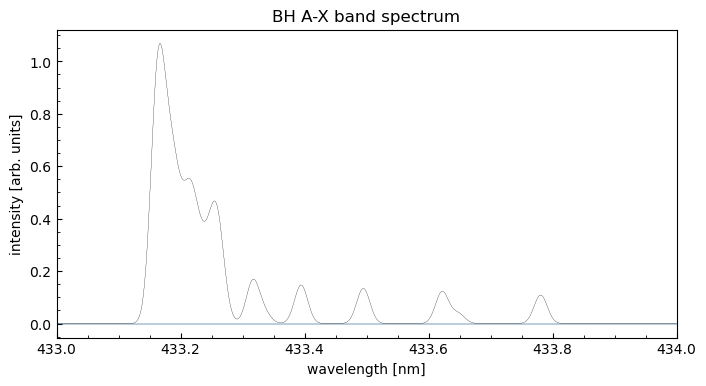

In [9]:
wl_data = np.arange(430, 436, 0.002)

C = 1
T_rot = 4000
w_inst = 0.025
T_tra = 0
I_R7 = 1e-3
I_R8 = 1e-3

int_P = BH_spec(wl_data, C, T_rot, w_inst, T_tra, 'P')
int_Q = BH_spec(wl_data, C, T_rot, w_inst, T_tra, 'Q')
int_R = BH_spec(wl_data, C, T_rot, w_inst, T_tra, 'R')
int_fit = BH_spec_fit(wl_data, C, T_rot, 0, w_inst, 0, I_R7, I_R8)

# グラフ (視線範囲は適当なので要調整)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.minorticks_on()
ax.set_xlim(433, 434)
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('intensity [arb. units]')
ax.set_title('BH A-X band spectrum')
ax.plot(wl_data, int_P, color='red', lw=0.2)
ax.plot(wl_data, int_Q, color='blue', lw=0.2)
ax.plot(wl_data, int_R, color='green', lw=0.2)
ax.plot(wl_data, int_fit, color='k', lw=0.2)
